In [12]:
%load_ext autoreload
%autoreload

import numpy as np
import pandas as pd
import pickle

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, GroupKFold
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns

from equationmodel_ann import ann_mlp_regression, prediction_rmse_error, ann_linear_compare_graph
from util import ADD_data_loader, combineDF, filteringDF, getFreeSpacePathLoss, makeXforGraphWithGroupingFrequency,\
                makeXforGraph, inverseScale, samplingData, normalizeData,train_2d_graph, train_3d_graph

desired_width=620
pd.set_option('display.width', desired_width)
pd.set_option('display.max_columns',30)
pd.options.display.float_format = "{:.2f}".format

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


ADD data preprocessing
../data/PLdata_iksan_wt_400.csv: distance filtering(before):(109210, 4)
../data/PLdata_iksan_wt_400.csv: distance filtering(after):(10396, 4)
../data/PLdata_iksan_wt_2249.csv: distance filtering(before):(108873, 4)
../data/PLdata_iksan_wt_2249.csv: distance filtering(after):(10396, 4)
../data/PLdata_iksan_wt_1399.csv: distance filtering(before):(109060, 4)
../data/PLdata_iksan_wt_1399.csv: distance filtering(after):(10396, 4)
          type  distance  pathloss  heightTM  frequency  heightTB  heightB  heightM
type 6367    m      2.97    111.22      0.02        400        30       15        2
     6368    m      2.96    115.43      0.02        400        30       15        2
     6369    m      2.96    111.62      0.02        400        30       15        2
     6370    m      2.95    108.95      0.02        400        30       15        2
     6371    m      2.94    103.93      0.02        400        30       15        2
Combined data set: (31188, 8)
type filterin

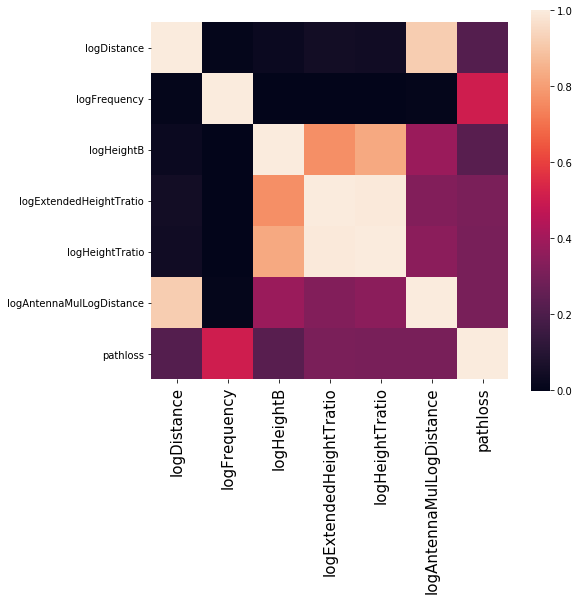

In [13]:
%autoreload

iksan_fileList = {'../data/PLdata_iksan_wt_400.csv':[('frequency', 400), ('heightTB',30), ('heightB',15), ('heightM',2)],
            '../data/PLdata_iksan_wt_1399.csv':[('frequency', 1399), ('heightTB',30), ('heightB',15), ('heightM',2)],
            '../data/PLdata_iksan_wt_2249.csv':[('frequency', 2249), ('heightTB',30), ('heightB',15), ('heightM',2)]}
nonsan_fileList = {'../data/PLdata_nonsan_wt_400.csv':[('frequency', 400), ('heightTB',30), ('heightB',15), ('heightM',2)],
            '../data/PLdata_nonsan_wt_1399.csv':[('frequency', 1399), ('heightTB',30), ('heightB',15), ('heightM',2)],
            '../data/PLdata_nonsan_wt_2249.csv':[('frequency', 2249), ('heightTB',30), ('heightB',15), ('heightM',2)]}
paju_fileList = {'../data/PLdata_paju_wt_400.csv':[('frequency', 400), ('heightTB',100), ('heightB',7), ('heightM',2)],
            '../data/PLdata_paju_wt_1399.csv':[('frequency', 1399), ('heightTB',100), ('heightB',7), ('heightM',2)],
            '../data/PLdata_paju_wt_2249.csv':[('frequency', 2249), ('heightTB',100), ('heightB',7), ('heightM',2)]}

addIksan = ADD_data_loader(iksan_fileList)
print("Iksan data:",addIksan.shape)
print("")
addNonsan = ADD_data_loader(nonsan_fileList)
print("Nonsan data:",addNonsan.shape)
print("")
addPaju = ADD_data_loader(paju_fileList)
print("Paju data:",addPaju.shape)
print("")

# print(addIksan.describe())
# print(addNonsan.describe())
# print(addPaju.describe())

addData = combineDF([addIksan, addNonsan, addPaju])
print("antenna_b height filtering-before(data count):",addData.shape)
addData = filteringDF(addData, 'heightTM', [10,100])
print("antenna_b height filtering-after(data count):",addData.shape)

print("freespace pathloss filtering-before(data count):",addData.shape)
addData['freePathloss'] = getFreeSpacePathLoss(addData['distance'],addData['frequency'])
addData = addData[addData['pathloss'] >= addData['freePathloss']]
print("freespace pathloss filtering-after(data count):",addData.shape)

# print("ADD data sample:\n",addData.head())

targetCols = ['logDistance', 'logFrequency', 'logHeightB', 'logHeightM','logExtendedHeightTratio', 'logHeightTratio', 'logAntennaMulLogDistance', 'pathloss']
xCols = ['logDistance', 'logFrequency', 'logHeightB', 'logHeightM','logExtendedHeightTratio', 'logHeightTratio', 'logAntennaMulLogDistance']
yCols = 'pathloss'

print("\nADD data description")
print(addData.describe()['pathloss'])
# print(addData[['logDistance', 'logFrequency', 'logHeightB', 'logHeightM', 'logHeightTratio', 'logAntennaMulLogDistance', 'pathloss']].describe())
print("\nCovariance Matrix - ADD data[pathloss]")
print(addData.cov()['pathloss'])
print("\nCovariance Matrix - ADD data[Target Columns]")
print("Target Columns:", targetCols)
print(addData[['logDistance', 'logFrequency', 'logHeightB', 'logExtendedHeightTratio', 'logHeightTratio', 'logAntennaMulLogDistance', 'pathloss']].cov()['pathloss'])

print("\nCorrelation Matrix - ADD data[Target Columns]")
print("Target Columns:", targetCols)
corrMat = addData[['logDistance', 'logFrequency', 'logHeightB', 'logExtendedHeightTratio', 'logHeightTratio', 'logAntennaMulLogDistance', 'pathloss']].corr()
print(corrMat)
f, ax = plt.subplots(figsize=(8,7))
sns.heatmap(corrMat, square=True)


In [14]:
%autoreload
samplingRatio = 0.7
addDataSample = samplingData(addData[targetCols], samplingRatio)
# addDataSample.sort_values(by=['logDistance'])

normalizer = 'manual'

X, scaler = normalizeData(addDataSample[xCols], scaler = normalizer)
Y = np.array(addDataSample[yCols])

data distribution(before)
       logDistance  logFrequency  logHeightB  logHeightM  logExtendedHeightTratio  logHeightTratio  logAntennaMulLogDistance  pathloss
count     79125.00      79125.00    79125.00    79125.00                 79125.00         79125.00                  79125.00  79125.00
mean          0.31          3.03        1.05        0.30                    -0.40            -0.32                      0.32    127.47
std           0.12          0.32        0.16        0.00                     0.26             0.33                      0.14     16.61
min           0.00          2.60        0.85        0.30                    -0.95            -1.00                      0.00     85.06
25%           0.23          2.60        0.85        0.30                    -0.62            -0.62                      0.24    114.91
50%           0.33          3.15        1.18        0.30                    -0.39            -0.27                      0.33    127.17
75%           0.40          3

In [4]:
print("ANN-MLP Regression train/test Error")
kf = KFold(n_splits=5, shuffle=True)

modelList = []
dataSet = []
i = 1
trainErrSum, testErrSum = 0, 0
for train_index, test_index in kf.split(X):
#     print("TRAIN index:", train_index, "TEST index:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = Y[train_index], Y[test_index]
    
    model = ann_mlp_regression(X_train, y_train.flatten(), (60,), activation='logistic', optimizer='lbfgs')

    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)
    
    trainError = np.sqrt(mean_squared_error(y_train, pred_train))
    testError = np.sqrt(mean_squared_error(y_test, pred_test))
    
    trainErrSum += trainError
    testErrSum += testError
    print("#"+str(i)+" Error(RMSE)-train:{} / test:{}".format(trainError,testError)) 
    
    dataSet.append([X_train,y_train,X_test,y_test, trainError, testError])
    
    modelList.append(model)
    filename = 'model/ann_model_' + str(i) + '.sav'
    pickle.dump(model, open(filename, 'wb'))
    i+=1
i-=1
avgTrainError, avgTestError = trainErrSum/i, testErrSum/i 
print("\nAverage train error:{:.2f} | Average test error:{:.2f}".format(avgTrainError, avgTestError))

ANN-MLP Regression train/test Error
#1 Error(RMSE)-train:11.205408772682954 / test:11.194645334116162
#2 Error(RMSE)-train:11.041453749784864 / test:11.144074415655682
#3 Error(RMSE)-train:10.918032647856569 / test:11.052468237472898
#4 Error(RMSE)-train:10.953542540021745 / test:11.031391811884221
#5 Error(RMSE)-train:10.883941394721598 / test:10.8994494829084

Average train error:11.00 | Average test error:11.06


Group-  0.26Ghz Data shape:(14688, 8)
Group-  0.31Ghz Data shape:(14946, 8)
Group-  0.34Ghz Data shape:(14676, 8)


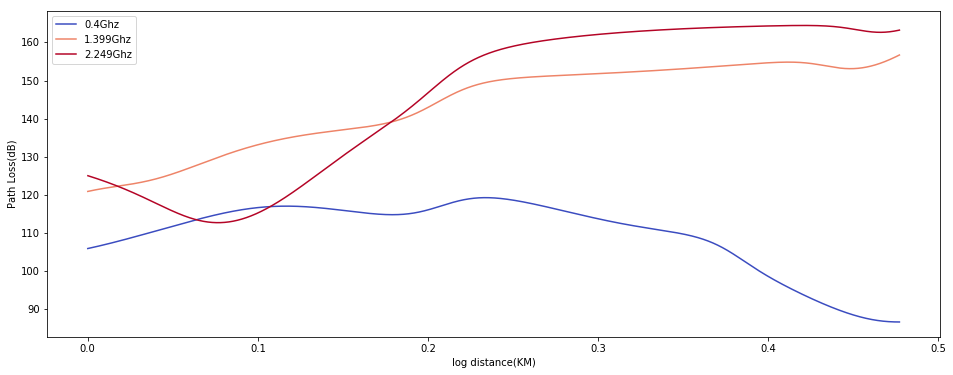

Group-  0.26Ghz Data shape:(14762, 8)
Group-  0.31Ghz Data shape:(14971, 8)
Group-  0.34Ghz Data shape:(14577, 8)


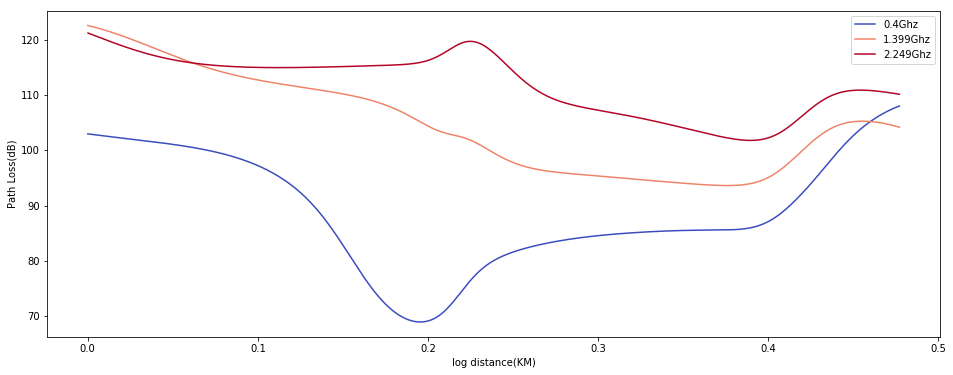

Group-  0.26Ghz Data shape:(14713, 8)
Group-  0.31Ghz Data shape:(14941, 8)
Group-  0.34Ghz Data shape:(14656, 8)


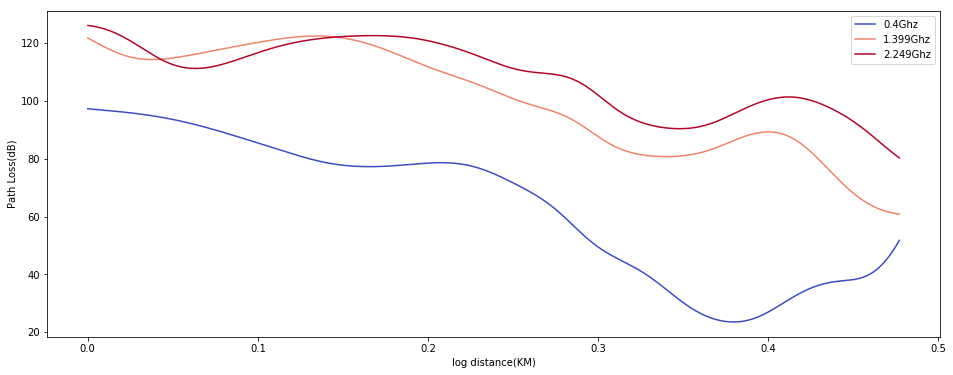

Group-  0.26Ghz Data shape:(14667, 8)
Group-  0.31Ghz Data shape:(14948, 8)
Group-  0.34Ghz Data shape:(14696, 8)


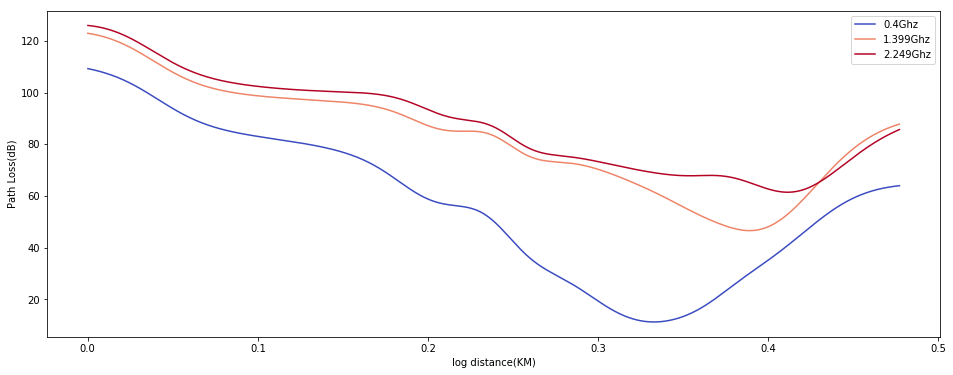

Group-  0.26Ghz Data shape:(14682, 8)
Group-  0.31Ghz Data shape:(14958, 8)
Group-  0.34Ghz Data shape:(14671, 8)


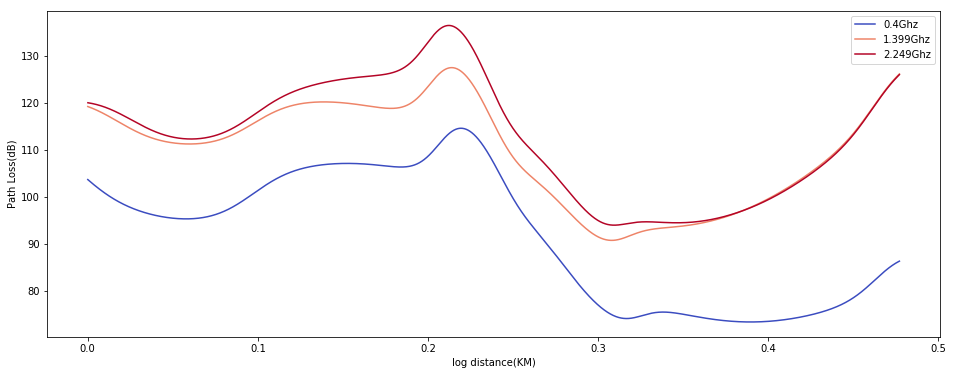

In [5]:
%autoreload
i = 1
for X_train,y_train,X_test,y_test, trainError, testError in dataSet:
#     X_train = scaler.inverse_transform(X_train)
    data = makeXforGraphWithGroupingFrequency(pd.DataFrame(X_train, columns=xCols),
                         pd.DataFrame(y_train, columns=['pathloss']), ['logHeightB', 'logHeightM','logExtendedHeightTratio', 'logHeightTratio'])

    model = pickle.load(open("model/ann_model_"+ str(i) +".sav", 'rb'))

    graphX = data[0]
    graphY = data[1]
    train_2d_graph(model, graphX, graphY, ['logDistance', 'logAntennaMulLogDistance'])
    i+=1

3D graph for log distance and log frequency - trainset #1
Index(['logDistance', 'logFrequency', 'logHeightB', 'logHeightM', 'logExtendedHeightTratio', 'logHeightTratio', 'logAntennaMulLogDistance'], dtype='object')
input data/feature distribution:
        logDistance  logFrequency  logHeightB  logHeightM  logExtendedHeightTratio  logHeightTratio  logAntennaMulLogDistance
count     10000.00      10000.00    10000.00    10000.00                 10000.00         10000.00                  10000.00
mean          0.31          0.30        0.11        0.30                    -0.40            -0.32                      0.28
std           0.00          0.02        0.00        0.00                     0.00             0.00                      0.16
min           0.31          0.26        0.11        0.30                    -0.40            -0.32                      0.00
25%           0.31          0.28        0.11        0.30                    -0.40            -0.32                      0.14
5

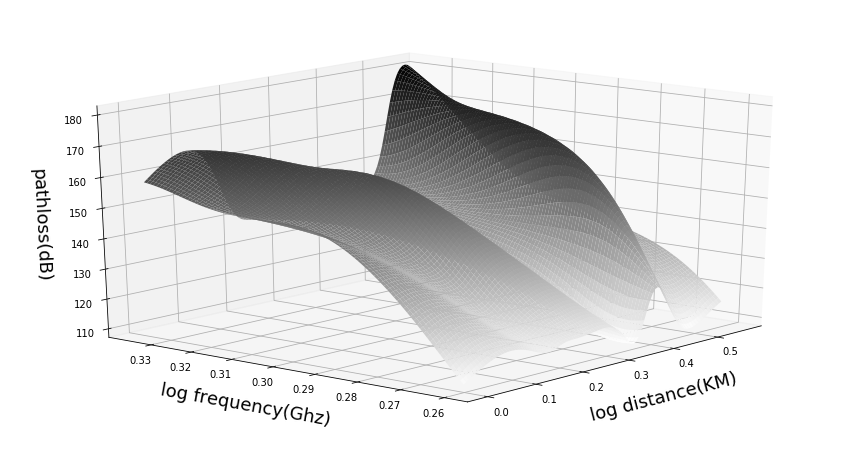

3D graph for log distance and log frequency - trainset #2
Index(['logDistance', 'logFrequency', 'logHeightB', 'logHeightM', 'logExtendedHeightTratio', 'logHeightTratio', 'logAntennaMulLogDistance'], dtype='object')
input data/feature distribution:
        logDistance  logFrequency  logHeightB  logHeightM  logExtendedHeightTratio  logHeightTratio  logAntennaMulLogDistance
count     10000.00      10000.00    10000.00    10000.00                 10000.00         10000.00                  10000.00
mean          0.31          0.30        0.11        0.30                    -0.40            -0.32                      0.28
std           0.00          0.02        0.00        0.00                     0.00             0.00                      0.16
min           0.31          0.26        0.11        0.30                    -0.40            -0.32                      0.00
25%           0.31          0.28        0.11        0.30                    -0.40            -0.32                      0.14
5

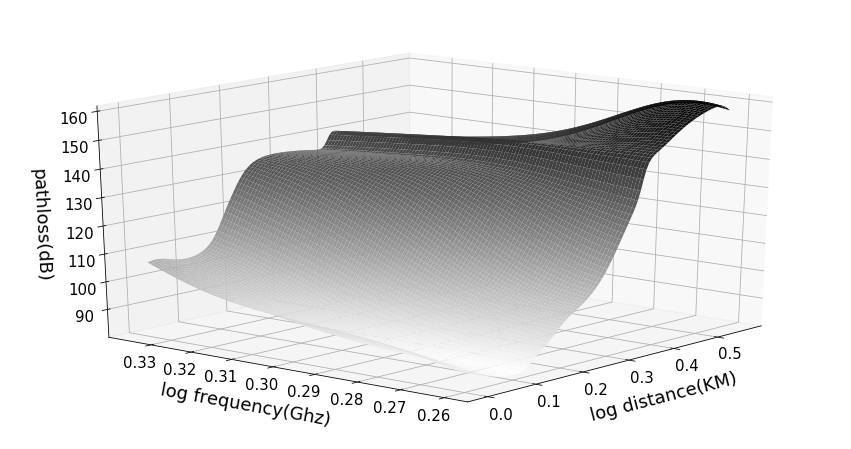

3D graph for log distance and log frequency - trainset #3
Index(['logDistance', 'logFrequency', 'logHeightB', 'logHeightM', 'logExtendedHeightTratio', 'logHeightTratio', 'logAntennaMulLogDistance'], dtype='object')
input data/feature distribution:
        logDistance  logFrequency  logHeightB  logHeightM  logExtendedHeightTratio  logHeightTratio  logAntennaMulLogDistance
count     10000.00      10000.00    10000.00    10000.00                 10000.00         10000.00                  10000.00
mean          0.31          0.30        0.11        0.30                    -0.40            -0.32                      0.28
std           0.00          0.02        0.00        0.00                     0.00             0.00                      0.16
min           0.31          0.26        0.11        0.30                    -0.40            -0.32                      0.00
25%           0.31          0.28        0.11        0.30                    -0.40            -0.32                      0.14
5

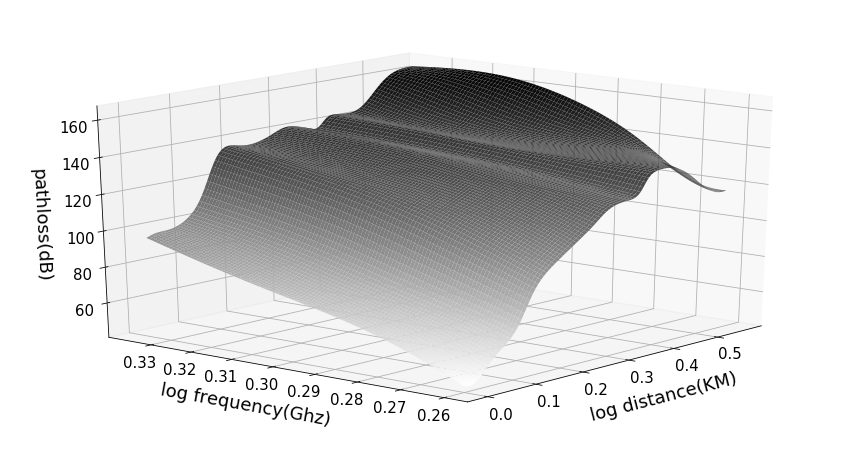

3D graph for log distance and log frequency - trainset #4
Index(['logDistance', 'logFrequency', 'logHeightB', 'logHeightM', 'logExtendedHeightTratio', 'logHeightTratio', 'logAntennaMulLogDistance'], dtype='object')
input data/feature distribution:
        logDistance  logFrequency  logHeightB  logHeightM  logExtendedHeightTratio  logHeightTratio  logAntennaMulLogDistance
count     10000.00      10000.00    10000.00    10000.00                 10000.00         10000.00                  10000.00
mean          0.31          0.30        0.11        0.30                    -0.40            -0.32                      0.28
std           0.00          0.02        0.00        0.00                     0.00             0.00                      0.16
min           0.31          0.26        0.11        0.30                    -0.40            -0.32                      0.00
25%           0.31          0.28        0.11        0.30                    -0.40            -0.32                      0.14
5

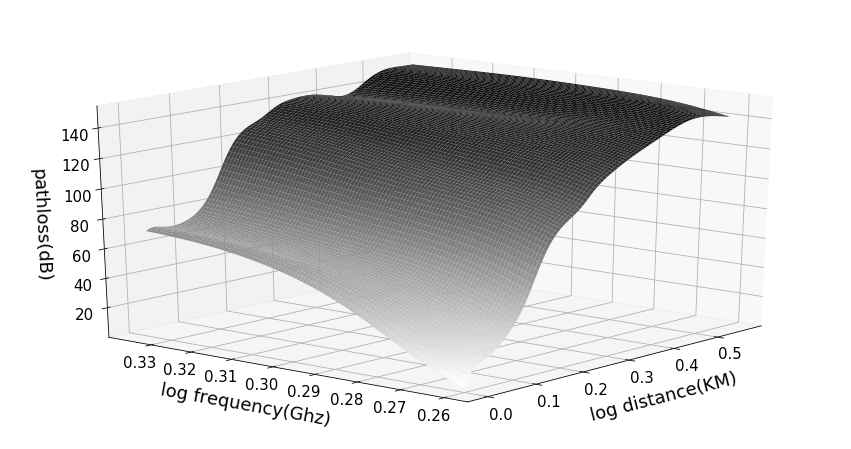

3D graph for log distance and log frequency - trainset #5
Index(['logDistance', 'logFrequency', 'logHeightB', 'logHeightM', 'logExtendedHeightTratio', 'logHeightTratio', 'logAntennaMulLogDistance'], dtype='object')
input data/feature distribution:
        logDistance  logFrequency  logHeightB  logHeightM  logExtendedHeightTratio  logHeightTratio  logAntennaMulLogDistance
count     10000.00      10000.00    10000.00    10000.00                 10000.00         10000.00                  10000.00
mean          0.31          0.30        0.11        0.30                    -0.40            -0.32                      0.28
std           0.00          0.02        0.00        0.00                     0.00             0.00                      0.16
min           0.31          0.26        0.11        0.30                    -0.40            -0.32                      0.00
25%           0.31          0.28        0.11        0.30                    -0.40            -0.32                      0.14
5

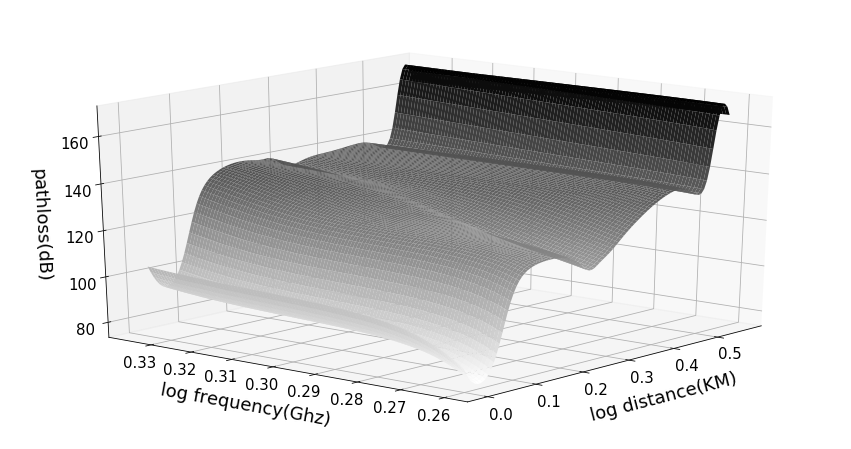

In [6]:
%autoreload
i = 1
for X_train,y_train,X_test,y_test, trainError, testError in dataSet:
    print("3D graph for log distance and log frequency - trainset #{}".format(i))
    targetCols = ['logAntennaMulLogDistance', 'logFrequency']
    xLabel,yLabel,zLabel = "log distance(KM)","log frequency(Ghz)","pathloss(dB)"
    data = makeXforGraph(pd.DataFrame(X_train, columns=xCols),
                         pd.DataFrame(y_train, columns=['pathloss']), targetCols)

    model = pickle.load(open("model/ann_model_"+ str(i) +".sav", 'rb'))

    graphX = data[0]
    graphY = data[1]
    train_3d_graph(model, graphX, graphY, targetCols, xLabel, yLabel, zLabel)
    i+=1

3D graph for log distance and log antenna height B+TB/M+TM ratio - trainset #1
Index(['logDistance', 'logFrequency', 'logHeightB', 'logHeightM', 'logExtendedHeightTratio', 'logHeightTratio', 'logAntennaMulLogDistance'], dtype='object')
input data/feature distribution:
        logDistance  logFrequency  logHeightB  logHeightM  logExtendedHeightTratio  logHeightTratio  logAntennaMulLogDistance
count     10000.00      10000.00    10000.00    10000.00                 10000.00         10000.00                  10000.00
mean          0.31          0.30        0.11        0.30                    -0.30            -0.32                      0.28
std           0.00          0.00        0.00        0.00                     0.38             0.00                      0.16
min           0.31          0.30        0.11        0.30                    -0.95            -0.32                      0.00
25%           0.31          0.30        0.11        0.30                    -0.63            -0.32       

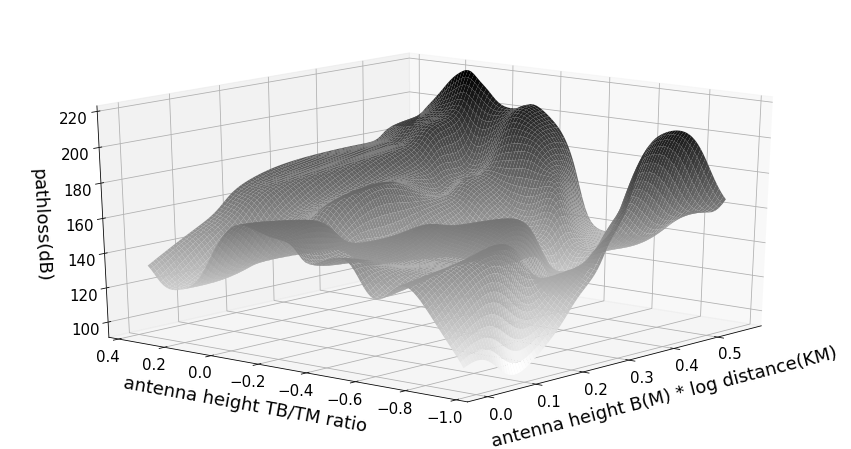

3D graph for log distance and log antenna height B+TB/M+TM ratio - trainset #2
Index(['logDistance', 'logFrequency', 'logHeightB', 'logHeightM', 'logExtendedHeightTratio', 'logHeightTratio', 'logAntennaMulLogDistance'], dtype='object')
input data/feature distribution:
        logDistance  logFrequency  logHeightB  logHeightM  logExtendedHeightTratio  logHeightTratio  logAntennaMulLogDistance
count     10000.00      10000.00    10000.00    10000.00                 10000.00         10000.00                  10000.00
mean          0.31          0.30        0.11        0.30                    -0.30            -0.32                      0.28
std           0.00          0.00        0.00        0.00                     0.38             0.00                      0.16
min           0.31          0.30        0.11        0.30                    -0.95            -0.32                      0.00
25%           0.31          0.30        0.11        0.30                    -0.63            -0.32       

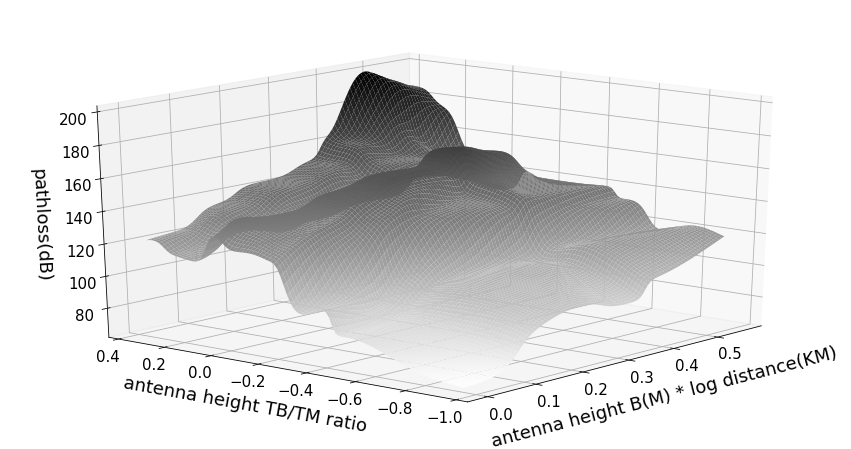

3D graph for log distance and log antenna height B+TB/M+TM ratio - trainset #3
Index(['logDistance', 'logFrequency', 'logHeightB', 'logHeightM', 'logExtendedHeightTratio', 'logHeightTratio', 'logAntennaMulLogDistance'], dtype='object')
input data/feature distribution:
        logDistance  logFrequency  logHeightB  logHeightM  logExtendedHeightTratio  logHeightTratio  logAntennaMulLogDistance
count     10000.00      10000.00    10000.00    10000.00                 10000.00         10000.00                  10000.00
mean          0.31          0.30        0.11        0.30                    -0.30            -0.32                      0.28
std           0.00          0.00        0.00        0.00                     0.38             0.00                      0.16
min           0.31          0.30        0.11        0.30                    -0.95            -0.32                      0.00
25%           0.31          0.30        0.11        0.30                    -0.63            -0.32       

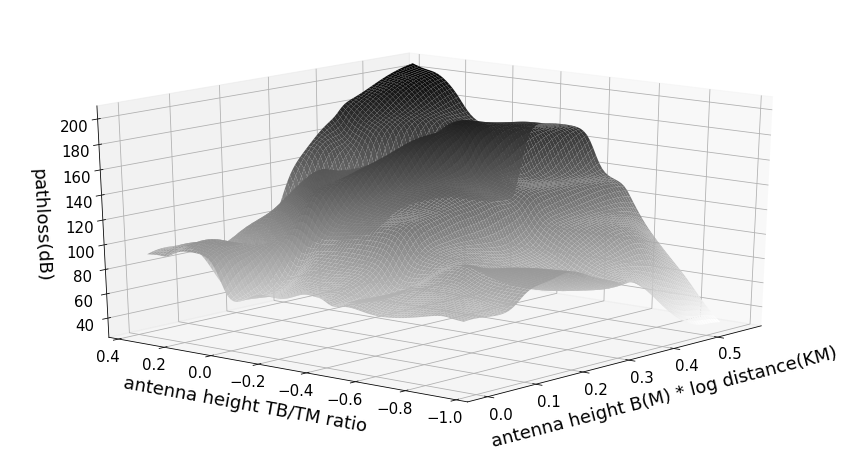

3D graph for log distance and log antenna height B+TB/M+TM ratio - trainset #4
Index(['logDistance', 'logFrequency', 'logHeightB', 'logHeightM', 'logExtendedHeightTratio', 'logHeightTratio', 'logAntennaMulLogDistance'], dtype='object')
input data/feature distribution:
        logDistance  logFrequency  logHeightB  logHeightM  logExtendedHeightTratio  logHeightTratio  logAntennaMulLogDistance
count     10000.00      10000.00    10000.00    10000.00                 10000.00         10000.00                  10000.00
mean          0.31          0.30        0.11        0.30                    -0.30            -0.32                      0.28
std           0.00          0.00        0.00        0.00                     0.38             0.00                      0.16
min           0.31          0.30        0.11        0.30                    -0.95            -0.32                      0.00
25%           0.31          0.30        0.11        0.30                    -0.63            -0.32       

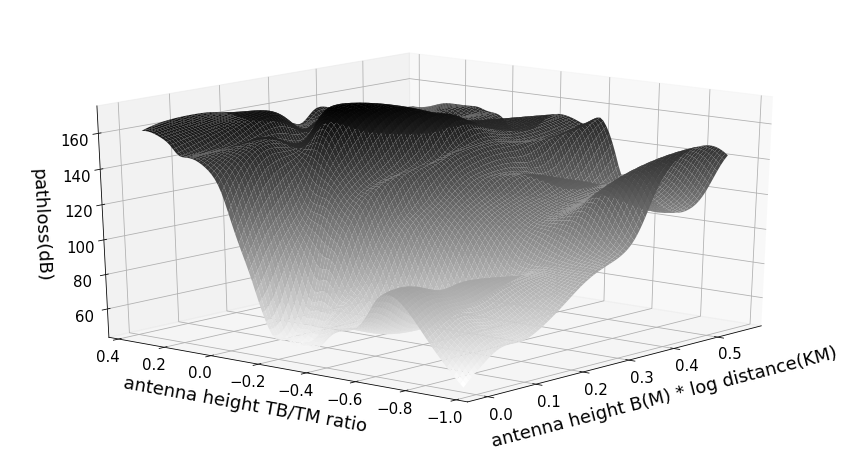

3D graph for log distance and log antenna height B+TB/M+TM ratio - trainset #5
Index(['logDistance', 'logFrequency', 'logHeightB', 'logHeightM', 'logExtendedHeightTratio', 'logHeightTratio', 'logAntennaMulLogDistance'], dtype='object')
input data/feature distribution:
        logDistance  logFrequency  logHeightB  logHeightM  logExtendedHeightTratio  logHeightTratio  logAntennaMulLogDistance
count     10000.00      10000.00    10000.00    10000.00                 10000.00         10000.00                  10000.00
mean          0.31          0.30        0.11        0.30                    -0.30            -0.32                      0.28
std           0.00          0.00        0.00        0.00                     0.38             0.00                      0.16
min           0.31          0.30        0.11        0.30                    -0.95            -0.32                      0.00
25%           0.31          0.30        0.11        0.30                    -0.63            -0.32       

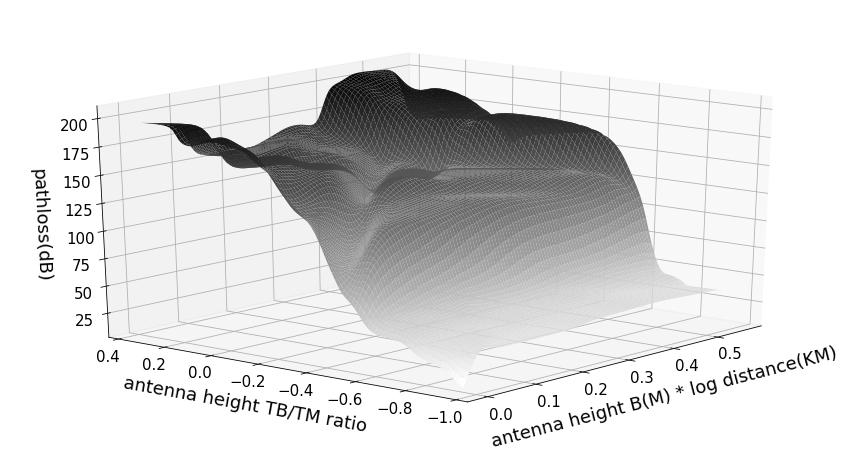

In [7]:
%autoreload
i = 1
for X_train,y_train,X_test,y_test, trainError, testError in dataSet:
    print("3D graph for log distance and log antenna height B+TB/M+TM ratio - trainset #{}".format(i))
    xLabel,yLabel,zLabel = "antenna height B(M) * log distance(KM)","antenna height TB/TM ratio","pathloss(dB)"
    varX = ['logAntennaMulLogDistance', 'logExtendedHeightTratio']
    data = makeXforGraph(pd.DataFrame(X_train, columns=xCols),
                         pd.DataFrame(y_train, columns=['pathloss']), varX)

    model = pickle.load(open("model/ann_model_"+ str(i) +".sav", 'rb'))

    graphX = data[0]
    graphY = data[1]
    train_3d_graph(model, graphX, graphY, varX, xLabel, yLabel, zLabel)
    i+=1

3D graph for log distance and log antenna height B ratio - trainset #1
Index(['logDistance', 'logFrequency', 'logHeightB', 'logHeightM', 'logExtendedHeightTratio', 'logHeightTratio', 'logAntennaMulLogDistance'], dtype='object')
input data/feature distribution:
        logDistance  logFrequency  logHeightB  logHeightM  logExtendedHeightTratio  logHeightTratio  logAntennaMulLogDistance
count     10000.00      10000.00    10000.00    10000.00                 10000.00         10000.00                  10000.00
mean          0.31          0.30        0.10        0.30                    -0.40            -0.32                      0.28
std           0.00          0.00        0.01        0.00                     0.00             0.00                      0.16
min           0.31          0.30        0.08        0.30                    -0.40            -0.32                      0.00
25%           0.31          0.30        0.09        0.30                    -0.40            -0.32               

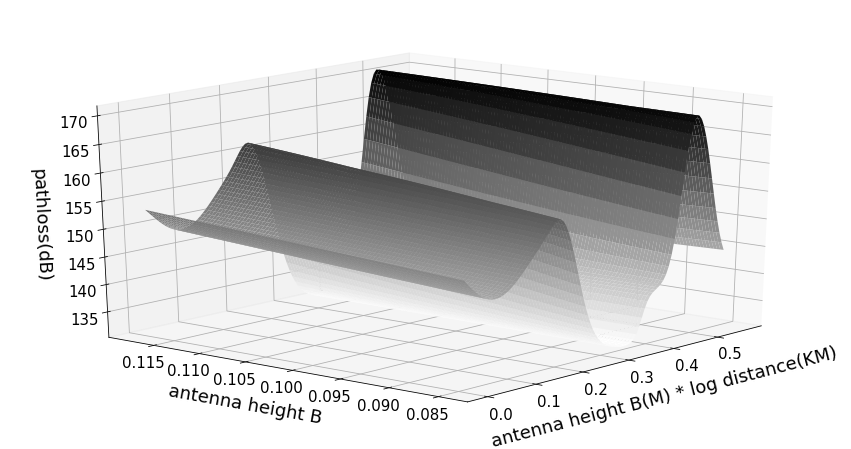

3D graph for log distance and log antenna height B ratio - trainset #2
Index(['logDistance', 'logFrequency', 'logHeightB', 'logHeightM', 'logExtendedHeightTratio', 'logHeightTratio', 'logAntennaMulLogDistance'], dtype='object')
input data/feature distribution:
        logDistance  logFrequency  logHeightB  logHeightM  logExtendedHeightTratio  logHeightTratio  logAntennaMulLogDistance
count     10000.00      10000.00    10000.00    10000.00                 10000.00         10000.00                  10000.00
mean          0.31          0.30        0.10        0.30                    -0.40            -0.32                      0.28
std           0.00          0.00        0.01        0.00                     0.00             0.00                      0.16
min           0.31          0.30        0.08        0.30                    -0.40            -0.32                      0.00
25%           0.31          0.30        0.09        0.30                    -0.40            -0.32               

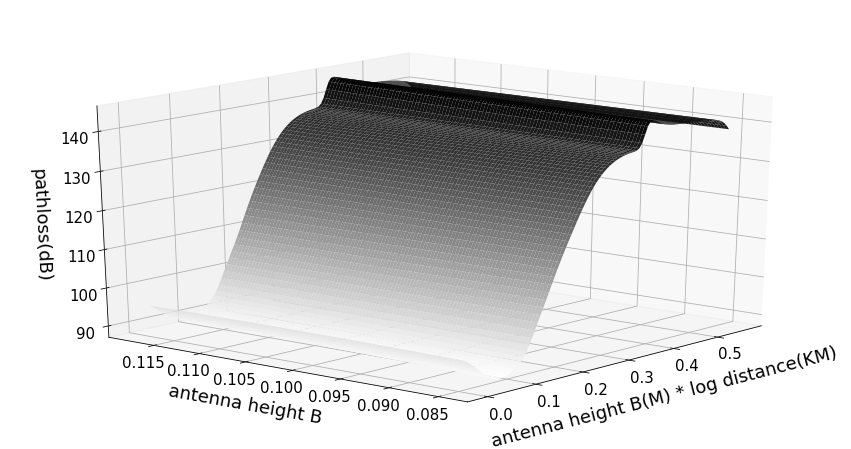

3D graph for log distance and log antenna height B ratio - trainset #3
Index(['logDistance', 'logFrequency', 'logHeightB', 'logHeightM', 'logExtendedHeightTratio', 'logHeightTratio', 'logAntennaMulLogDistance'], dtype='object')
input data/feature distribution:
        logDistance  logFrequency  logHeightB  logHeightM  logExtendedHeightTratio  logHeightTratio  logAntennaMulLogDistance
count     10000.00      10000.00    10000.00    10000.00                 10000.00         10000.00                  10000.00
mean          0.31          0.30        0.10        0.30                    -0.40            -0.32                      0.28
std           0.00          0.00        0.01        0.00                     0.00             0.00                      0.16
min           0.31          0.30        0.08        0.30                    -0.40            -0.32                      0.00
25%           0.31          0.30        0.09        0.30                    -0.40            -0.32               

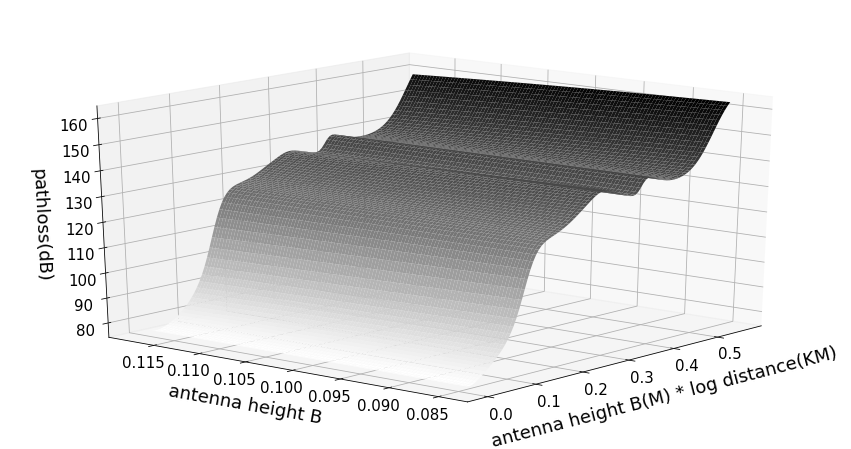

3D graph for log distance and log antenna height B ratio - trainset #4
Index(['logDistance', 'logFrequency', 'logHeightB', 'logHeightM', 'logExtendedHeightTratio', 'logHeightTratio', 'logAntennaMulLogDistance'], dtype='object')
input data/feature distribution:
        logDistance  logFrequency  logHeightB  logHeightM  logExtendedHeightTratio  logHeightTratio  logAntennaMulLogDistance
count     10000.00      10000.00    10000.00    10000.00                 10000.00         10000.00                  10000.00
mean          0.31          0.30        0.10        0.30                    -0.40            -0.32                      0.28
std           0.00          0.00        0.01        0.00                     0.00             0.00                      0.16
min           0.31          0.30        0.08        0.30                    -0.40            -0.32                      0.00
25%           0.31          0.30        0.09        0.30                    -0.40            -0.32               

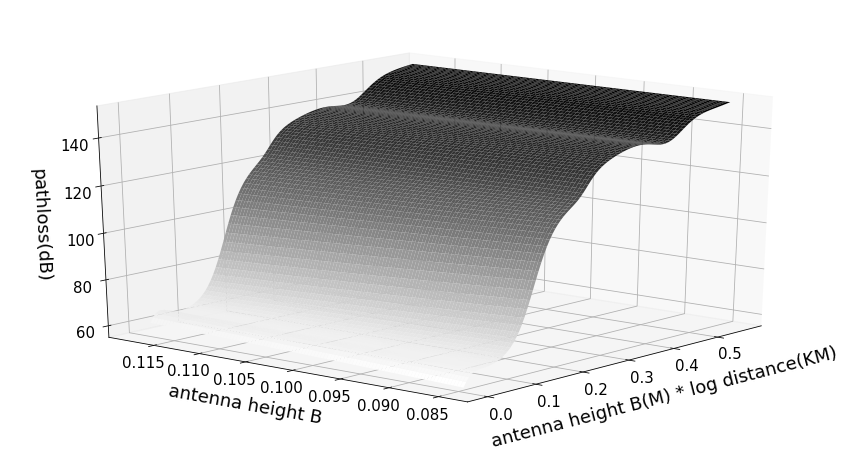

3D graph for log distance and log antenna height B ratio - trainset #5
Index(['logDistance', 'logFrequency', 'logHeightB', 'logHeightM', 'logExtendedHeightTratio', 'logHeightTratio', 'logAntennaMulLogDistance'], dtype='object')
input data/feature distribution:
        logDistance  logFrequency  logHeightB  logHeightM  logExtendedHeightTratio  logHeightTratio  logAntennaMulLogDistance
count     10000.00      10000.00    10000.00    10000.00                 10000.00         10000.00                  10000.00
mean          0.31          0.30        0.10        0.30                    -0.40            -0.32                      0.28
std           0.00          0.00        0.01        0.00                     0.00             0.00                      0.16
min           0.31          0.30        0.08        0.30                    -0.40            -0.32                      0.00
25%           0.31          0.30        0.09        0.30                    -0.40            -0.32               

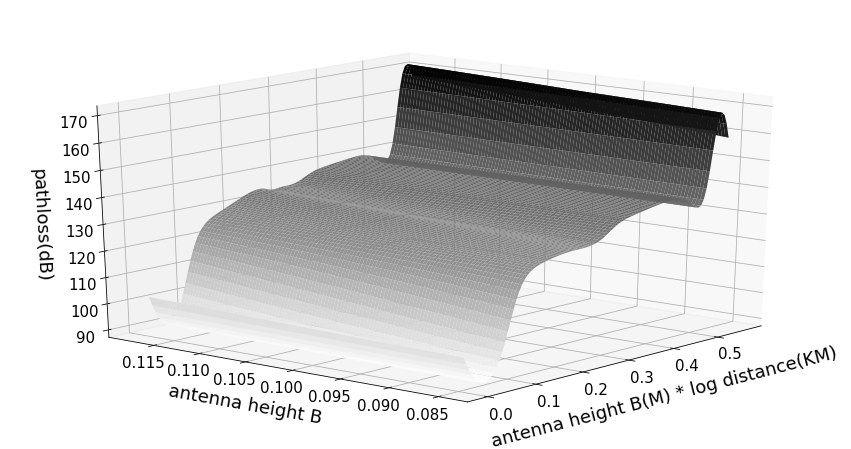

In [8]:
%autoreload
i = 1
for X_train,y_train,X_test,y_test, trainError, testError in dataSet:
    print("3D graph for log distance and log antenna height B ratio - trainset #{}".format(i))
    varX = ['logAntennaMulLogDistance', 'logHeightB']
    xLabel,yLabel,zLabel = "antenna height B(M) * log distance(KM)","antenna height B","pathloss(dB)"
    data = makeXforGraph(pd.DataFrame(X_train, columns=xCols),
                         pd.DataFrame(y_train, columns=['pathloss']), varX)

    model = pickle.load(open("model/ann_model_"+ str(i) +".sav", 'rb'))

    graphX = data[0]
    graphY = data[1]
    train_3d_graph(model, graphX, graphY, varX, xLabel, yLabel, zLabel)
    i+=1

Equation Derivation for trainset #1
Group-  0.26Ghz Data shape:(14688, 8)
Group-  0.31Ghz Data shape:(14946, 8)
Group-  0.34Ghz Data shape:(14676, 8)
ANN-Model-1-train error(RMSE): 11.205408772682954
ANN-Model-1-test error(RMSE): 11.194645334116162
MultiLinear-1-train error(RMSE): 24.032854759394418
MultiLinear-1-test error(RMSE): 24.01111267454788

Objective Function with manual normalization data
L_pathloss = (-53.40 +  37.13log_hb)log_d + 161.00log_f + -9381.23log_hb +  -0.00log_hm + -263.60log_(h_tb + h_b/h_tm + h_m) + 250.68log_(h_tb/h_tm) + 217.90
RMSE(ANN-MultiLinear): 4.521987642317145


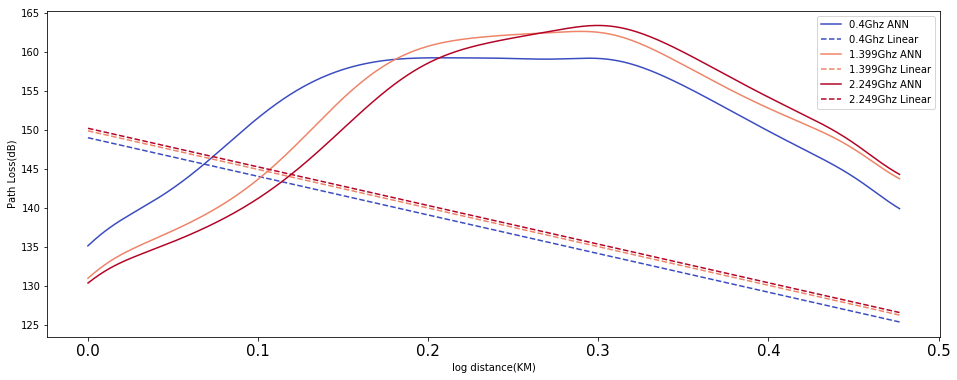

Equation Derivation for trainset #2
Group-  0.26Ghz Data shape:(14762, 8)
Group-  0.31Ghz Data shape:(14971, 8)
Group-  0.34Ghz Data shape:(14577, 8)
ANN-Model-2-train error(RMSE): 11.041453749784864
ANN-Model-2-test error(RMSE): 11.144074415655682
MultiLinear-2-train error(RMSE): 19.564895081969
MultiLinear-2-test error(RMSE): 19.54195257542629

Objective Function with manual normalization data
L_pathloss = ( 76.44 + -64.18log_hb)log_d + -88.47log_f + 18636.44log_hb +  -0.00log_hm + 575.95log_(h_tb + h_b/h_tm + h_m) + -523.53log_(h_tb/h_tm) +   5.03
RMSE(ANN-MultiLinear): 4.246710654752876


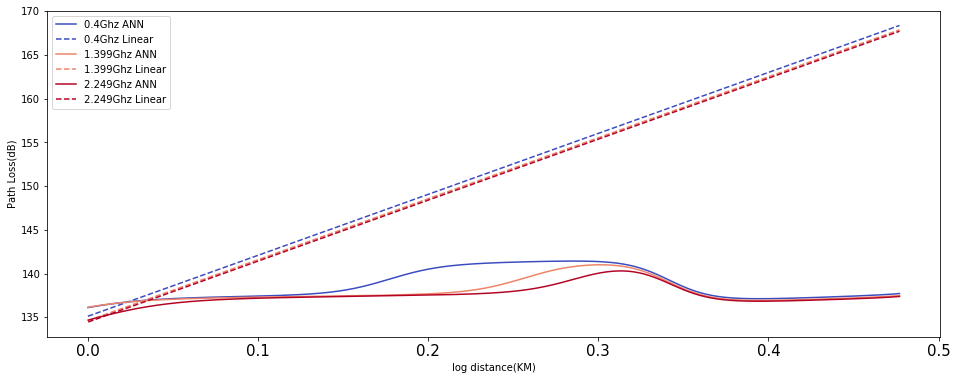

Equation Derivation for trainset #3
Group-  0.26Ghz Data shape:(14713, 8)
Group-  0.31Ghz Data shape:(14941, 8)
Group-  0.34Ghz Data shape:(14656, 8)
ANN-Model-3-train error(RMSE): 10.918032647856569
ANN-Model-3-test error(RMSE): 11.052468237472898
MultiLinear-3-train error(RMSE): 19.664158438916658
MultiLinear-3-test error(RMSE): 19.661503371782743

Objective Function with manual normalization data
L_pathloss = ( 20.42 + -53.12log_hb)log_d + 110.31log_f + -3095.22log_hb +  -0.00log_hm + -151.32log_(h_tb + h_b/h_tm + h_m) + 132.49log_(h_tb/h_tm) + 143.39
RMSE(ANN-MultiLinear): 3.3734669398620887


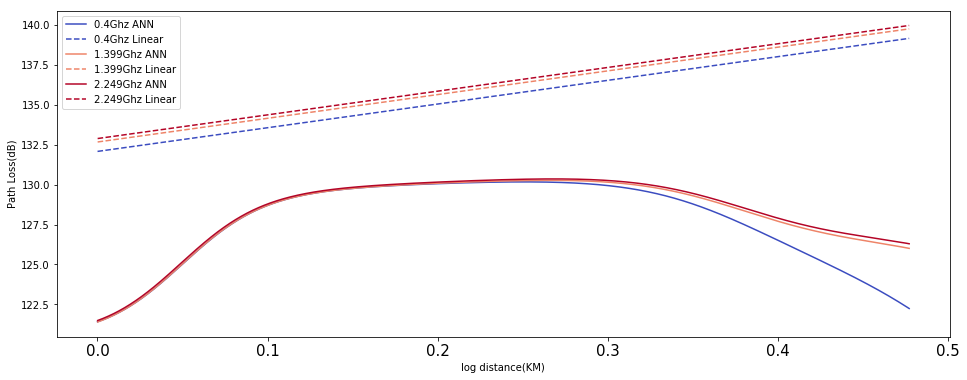

Equation Derivation for trainset #4
Group-  0.26Ghz Data shape:(14667, 8)
Group-  0.31Ghz Data shape:(14948, 8)
Group-  0.34Ghz Data shape:(14696, 8)
ANN-Model-4-train error(RMSE): 10.953542540021745
ANN-Model-4-test error(RMSE): 11.031391811884221
MultiLinear-4-train error(RMSE): 27.696280635307613
MultiLinear-4-test error(RMSE): 27.565893122727548

Objective Function with manual normalization data
L_pathloss = (235.10 + -236.71log_hb)log_d +  53.00log_f + 4939.59log_hb +  -0.00log_hm + -36.78log_(h_tb + h_b/h_tm + h_m) +  25.81log_(h_tb/h_tm) +  91.24
RMSE(ANN-MultiLinear): 6.561853592063306


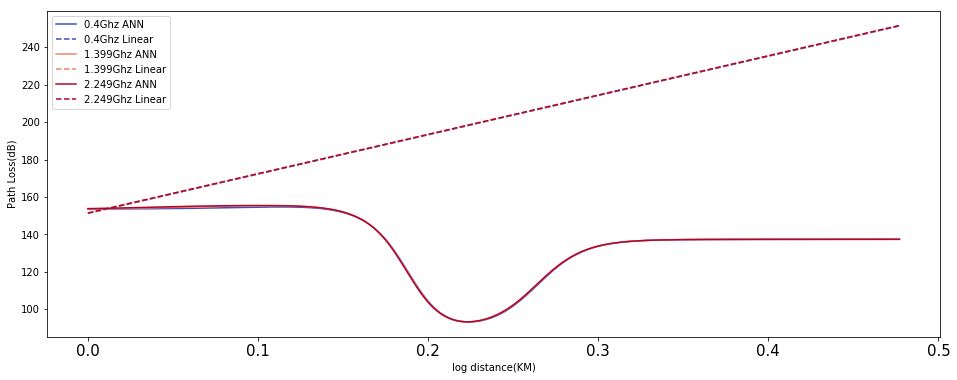

Equation Derivation for trainset #5
Group-  0.26Ghz Data shape:(14682, 8)
Group-  0.31Ghz Data shape:(14958, 8)
Group-  0.34Ghz Data shape:(14671, 8)
ANN-Model-5-train error(RMSE): 10.883941394721598
ANN-Model-5-test error(RMSE): 10.8994494829084
MultiLinear-5-train error(RMSE): 18.265993882756117
MultiLinear-5-test error(RMSE): 18.211277036218284

Objective Function with manual normalization data
L_pathloss = (-230.50 + 197.53log_hb)log_d + -27.83log_f + 7262.18log_hb +  -0.00log_hm + 471.35log_(h_tb + h_b/h_tm + h_m) + -433.83log_(h_tb/h_tm) + 110.55
RMSE(ANN-MultiLinear): 5.478734888260409


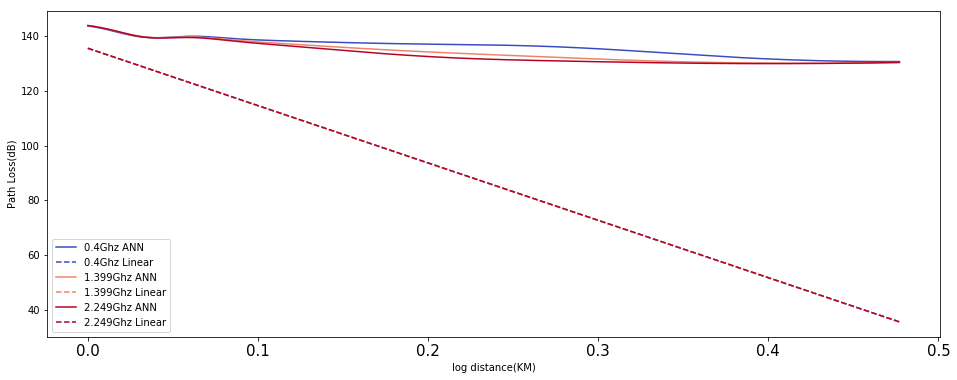


AVG Objective Function
L_pathloss = (  9.61 + -23.87log_hb)log_d +   4.16log_f + 367.24log_hb +  -0.00log_hm + 119.12log_(h_tb + h_b/h_tm + h_m) + -109.67log_(h_tb/h_tm) + 113.62
object function error(RMSE): 19.42346152582572


In [16]:
%autoreload

#logDistance  logFrequency  logHeightB  logHeightM  logExtendedHeightTratio  logHeightTratio  logAntennaMulLogDistance
i = 1
coefSum, interceptSum = np.array([0]*7), 0
for X_train, y_train, X_test, y_test, trainError, testError in dataSet:
    print("="*120)
    print("Equation Derivation for trainset #{}".format(i))
    data = makeXforGraphWithGroupingFrequency(pd.DataFrame(X_train, columns=xCols),
                         pd.DataFrame(y_train, columns=['pathloss']), ['logHeightB', 'logHeightM','logExtendedHeightTratio', 'logHeightTratio'])

    ANNmodel = pickle.load(open("model/ann_model_"+ str(i) +".sav", 'rb'))
    ANNPred = ANNmodel.predict(X_train)
    
    linearModel = Ridge(alpha=0.001).fit(X_train, ANNPred)     
    linearPredTrain = linearModel.predict(X_train)
    linearPredTest = linearModel.predict(X_test)
    
    RMSE_LIN_TRAIN = np.sqrt(mean_squared_error(linearPredTrain, y_train))
    RMSE_LIN_TEST = np.sqrt(mean_squared_error(linearPredTest, y_test))
    
    RMSE_LIN_ANN = np.sqrt(mean_squared_error(ANNPred, linearPredTrain))

    print("ANN-Model-"+str(i)+"-train error(RMSE):", trainError)
    print("ANN-Model-"+str(i)+"-test error(RMSE):", testError)  
    print("MultiLinear-"+str(i)+"-train error(RMSE):",RMSE_LIN_TRAIN)
    print("MultiLinear-"+str(i)+"-test error(RMSE):",RMSE_LIN_TEST)
    
    print("\nObjective Function with manual normalization data")
    print("L_pathloss = ({:6.2f} + {:6.2f}log_hb)log_d + {:6.2f}log_f + {:6.2f}log_hb + {:6.2f}log_hm + {:6.2f}log_(h_tb + h_b/h_tm + h_m) + {:6.2f}log_(h_tb/h_tm) + {:6.2f}"\
          .format(linearModel.coef_[0],linearModel.coef_[6],linearModel.coef_[1]*10,\
                  linearModel.coef_[2]*10,linearModel.coef_[3],linearModel.coef_[4], linearModel.coef_[5], linearModel.intercept_))    
    coefSum = np.add(linearModel.coef_, coefSum)
    interceptSum = np.add(linearModel.intercept_, interceptSum)
    print("RMSE(ANN-MultiLinear):", RMSE_LIN_ANN)
    graphX = data[0]
    graphY = data[1]
    ann_linear_compare_graph(ANNmodel, linearModel, graphX, graphY)

    i+=1
i-=1
avgCoef = np.divide(coefSum,i)
avgIntercept = np.divide(interceptSum,i)
#logDistance  logFrequency  logHeightB  logHeightM  logExtendedHeightTratio  logHeightTratio  logAntennaMulLogDistance
print("\nAVG Objective Function")
print("L_pathloss = ({:6.2f} + {:6.2f}log_hb)log_d + {:6.2f}log_f + {:6.2f}log_hb + {:6.2f}log_hm + {:6.2f}log_(h_tb + h_b/h_tm + h_m) + {:6.2f}log_(h_tb/h_tm) + {:6.2f}"\
      .format(avgCoef[0],avgCoef[6],avgCoef[1],\
              avgCoef[2],avgCoef[3],avgCoef[4], avgCoef[5], avgIntercept)) 
f = lambda x: avgCoef[0]*x[:,0] + avgCoef[6]*x[:,6] + avgCoef[1] * x[:,1] + avgCoef[2]*x[:,2] + avgCoef[3]*x[:,3] + avgCoef[4]*x[:,4] + avgCoef[5]*x[:,5] + avgIntercept
pred = f(X)
error = np.sqrt(mean_squared_error(pred, Y.flatten()))
print("object function error(RMSE):",error)